In [33]:

import matplotlib.pyplot as plt
plt.style.use('/home/joliveira/Documents/termoionico/joao.mplstyle')
# --- DEFINIÇÃO DO TEMA GLOBAL USANDO rcParams ---
plt.rcParams['figure.figsize'] = (20, 12) # Define o tamanho da figura para 10x6 polegadas
plt.rcParams['font.size'] = 14           # Define o tamanho da fonte geral como 14
plt.rcParams['axes.titlesize'] = 25      # Tamanho da fonte do título
plt.rcParams['axes.labelsize'] = 20      # Tamanho da fonte dos rótulos dos eixos
plt.rcParams['axes.grid'] = True        # Habilita/desabilita a grade em todos os gráficos
plt.rcParams['grid.linestyle'] = '-'      # Estilo da grade: tracejado
plt.rcParams['grid.alpha'] = 0.6         # Transparência da grade
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['savefig.dpi'] = 700        # Alta resolução para salvar as figuras
plt.rcParams['lines.linestyle'] = '-'    # Linha sólida
plt.rcParams['lines.linewidth'] = 3   # Espessura da linha
plt.rcParams['figure.facecolor'] = 'none'   # Fundo da figura transparente
plt.rcParams['axes.facecolor']   = 'none'   # Fundo dos eixos transparente
plt.rcParams['savefig.facecolor'] = 'none'  # Ao salvar, mantém transparente
plt.rcParams['savefig.transparent'] = True  # Salva figuras com fundo transparente
plt.rcParams['xtick.labelsize'] = 16    # Tamanho dos rótulos do eixo x
plt.rcParams['ytick.labelsize'] = 16    # Tamanho dos rótulos do eixo y
# ---------------------------------------------------



Missing colon in file '/home/joliveira/Documents/termoionico/joao.mplstyle', line 617 ('view raw')
Missing colon in file '/home/joliveira/Documents/termoionico/joao.mplstyle', line 618 ('matplotlibrc hosted with ❤ by GitHub')


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Fator de conversão calculado anteriormente (T por A)
K = 7.79e-4   # T / A

def plot_campo_vs_Ieq(
    caminho_arquivo: str,
    salvar: bool = False,
    pasta_saida: str = None,
    mostrar_erro: bool = True
):
    """
    Lê o arquivo .ods contendo:
    - I_Bob (A)
    - Erro I_Bob (A)
    - I_Eq (A)
    - Erro I_Eq (A)

    Converte:
        • I_Bob → B (mT)
        • I_Eq  → microampere (µA)

    Plota B(mT) no eixo X vs I_Eq(µA) no eixo Y.

    Novo parâmetro:
        mostrar_erro (bool): se False, não desenha barras de erro
    """

    # Ler planilha (ods/xls/xlsx conforme engine)
    df = pd.read_excel(caminho_arquivo, engine="odf")

    # Checar colunas
    colunas_necessarias = [
        "I_Bob (A)", "Erro I_Bob (A)",
        "I_Eq (A)", "Erro I_Eq (A)"
    ]
    for col in colunas_necessarias:
        if col not in df.columns:
            raise ValueError(f"Coluna '{col}' não encontrada no arquivo.")

    # Converter corrente das bobinas para campo magnético (T)
    df["B (T)"] = K * df["I_Bob (A)"]
    df["Erro B (T)"] = K * df["Erro I_Bob (A)"]

    # Converter T → mT
    df["B (mT)"] = df["B (T)"] * 1e3
    df["Erro B (mT)"] = df["Erro B (T)"] * 1e3

    # Converter I_Eq para microampere
    df["I_Eq (µA)"] = df["I_Eq (A)"] * 1e6
    df["Erro I_Eq (µA)"] = df["Erro I_Eq (A)"] * 1e6

    # --- Plot ---
    if mostrar_erro:
        plt.errorbar(
            df["B (mT)"],
            df["I_Eq (µA)"],
            xerr=df["Erro B (mT)"],
            yerr=df["Erro I_Eq (µA)"],
            fmt='o',
            ecolor='gray',
            capsize=4,
            label="Dados experimentais"
        )
    else:
        plt.plot(
            df["B (mT)"],
            df["I_Eq (µA)"],
            'o',
            label="Dados experimentais"
        )

    plt.xlabel("Campo magnético B (mT)")
    plt.ylabel("Corrente equivalente I_Eq (µA)")
    plt.title("B (mT) vs I_Eq (µA)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Salvar opcionalmente
    if salvar:
        if pasta_saida is None:
            raise ValueError("Você deve fornecer 'pasta_saida' quando salvar=True.")
        os.makedirs(pasta_saida, exist_ok=True)

        nome_arq = (
            os.path.splitext(os.path.basename(caminho_arquivo))[0]
            + "_B_vs_Ieq_mT_microA.png"
        )
        caminho_saida = os.path.join(pasta_saida, nome_arq)
        plt.savefig(caminho_saida, dpi=300, bbox_inches="tight")
        print(f"✅ Gráfico salvo em: {caminho_saida}")

    plt.show()


✅ Gráfico salvo em: Gráficos Parte 2/m_3-T_1600C_B_vs_Ieq_mT_microA.png


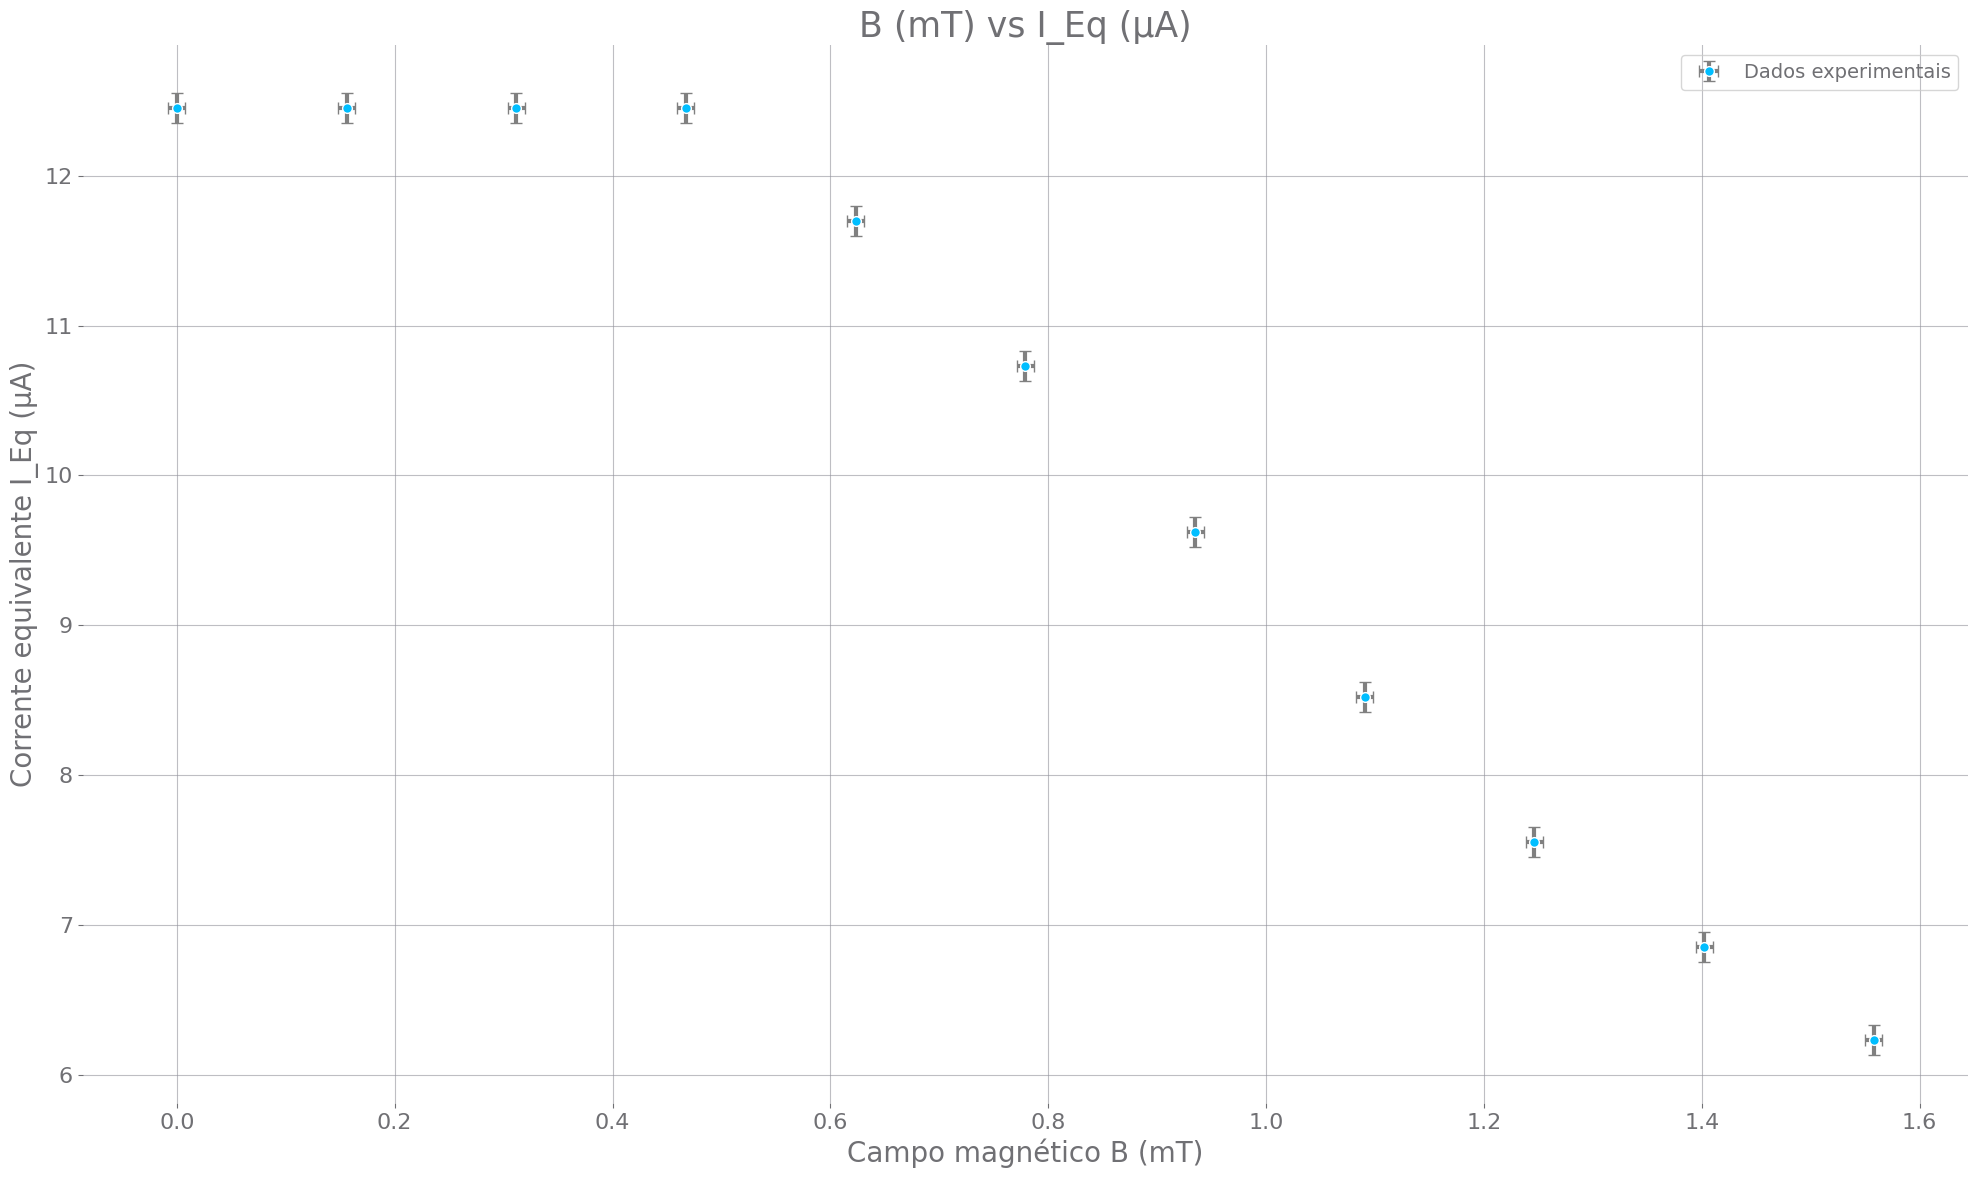

In [35]:
caminho = "/home/joliveira/Documents/termoionico/Dados Obitdos 27.11.2025/"
plot_campo_vs_Ieq(f"{caminho}m_3-T_1600C.ods", salvar=True, pasta_saida="Gráficos Parte 2")

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

K = 7.79e-4   # T/A

# Modelo piecewise: duas retas conectadas em x0
def piecewise_linear(x, x0, k1, b1, k2):
    """
    Modelo:
        y = k1*x + b1                (x < x0)
        y = k2*(x - x0) + (k1*x0+b1) (x >= x0)
    """
    return np.where(
        x < x0,
        k1 * x + b1,
        k2 * (x - x0) + (k1 * x0 + b1)
    )


def plot_piecewise_knee(
    caminho_arquivo: str,
    salvar: bool = False,
    pasta_saida: str = None,
    mostrar_erro: bool = True
):
    """
    L� o arquivo, converte:
        - I_Bob \u2192 B (mT)
        - I_Eq  \u2192 �A

    Ajusta um modelo piecewise (2 retas) para detectar o ponto de joelho.

    Par�metros:
        caminho_arquivo (str): planilha
        salvar (bool): salva o gr�fico
        pasta_saida (str): pasta onde salvar
        mostrar_erro (bool): se False, n�o mostra barras de erro
    """

    df = pd.read_excel(caminho_arquivo, engine="odf")

    colunas_necessarias = ["I_Bob (A)", "Erro I_Bob (A)", "I_Eq (A)", "Erro I_Eq (A)"]
    for col in colunas_necessarias:
        if col not in df.columns:
            raise ValueError(f"Coluna '{col}' n�o encontrada no arquivo.")

    # ---- CONVERS�ES ----
    df["B (T)"] = K * df["I_Bob (A)"]
    df["Erro B (T)"] = K * df["Erro I_Bob (A)"]

    df["B (mT)"] = df["B (T)"] * 1e3
    df["Erro B (mT)"] = df["Erro B (T)"] * 1e3

    df["I_Eq (�A)"] = df["I_Eq (A)"] * 1e6
    df["Erro I_Eq (�A)"] = df["Erro I_Eq (A)"] * 1e6

    # Dados para o fit
    x = df["B (mT)"].values
    y = df["I_Eq (�A)"].values

    # Chute inicial para os par�metros
    x0_init = x[len(x)//2]
    k1_init = (y[1] - y[0]) / (x[1] - x[0])
    k2_init = (y[-1] - y[-2]) / (x[-1] - x[-2])
    b1_init = y[0] - k1_init * x[0]

    p0 = [x0_init, k1_init, b1_init, k2_init]

    # ---- AJUSTE PIECEWISE ----
    popt, pcov = curve_fit(piecewise_linear, x, y, p0=p0)

    x0, k1, b1, k2 = popt
    knee_y = piecewise_linear(x0, *popt)

    # Gera curvas suaves para o plot
    x_fit = np.linspace(min(x), max(x), 300)
    y_fit = piecewise_linear(x_fit, *popt)

    # ---- PLOT ----
    if mostrar_erro:
        plt.errorbar(
            df["B (mT)"],
            df["I_Eq (�A)"],
            xerr=df["Erro B (mT)"],
            yerr=df["Erro I_Eq (�A)"],
            fmt='o',
            ecolor='gray',
            capsize=4,
            label="Dados experimentais"
        )
    else:
        plt.plot(
            df["B (mT)"],
            df["I_Eq (�A)"],
            'o',
            label="Dados experimentais"
        )

    # Curva ajustada
    plt.plot(x_fit, y_fit, '--r', label="Ajuste piecewise")

    # Ponto de joelho
    plt.scatter([x0], [knee_y], color='black', s=80, zorder=5, label=f"Dobra = {x0:.3f} mT")

    plt.xlabel("Campo magn�tico B (mT)")
    plt.ylabel("Corrente equivalente I_Eq (�A)")
    plt.title("Ajuste Piecewise Linear \u2013 Determina��o da dobra (knee)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if salvar:
        if pasta_saida is None:
            raise ValueError("Voc� deve fornecer 'pasta_saida' quando salvar=True.")
        os.makedirs(pasta_saida, exist_ok=True)
        nome = os.path.splitext(os.path.basename(caminho_arquivo))[0] + "_knee_piecewise.png"
        caminho_saida = os.path.join(pasta_saida, nome)
        plt.savefig(caminho_saida, dpi=300, bbox_inches="tight")
        print(f"\u2705 Gr�fico salvo em: {caminho_saida}")

    plt.show()

    # Retorna o valor do ponto de dobra
    return x0, knee_y


✅ Gr�fico salvo em: Gráficos Parte 2/m_3-T_1700C_knee_piecewise.png


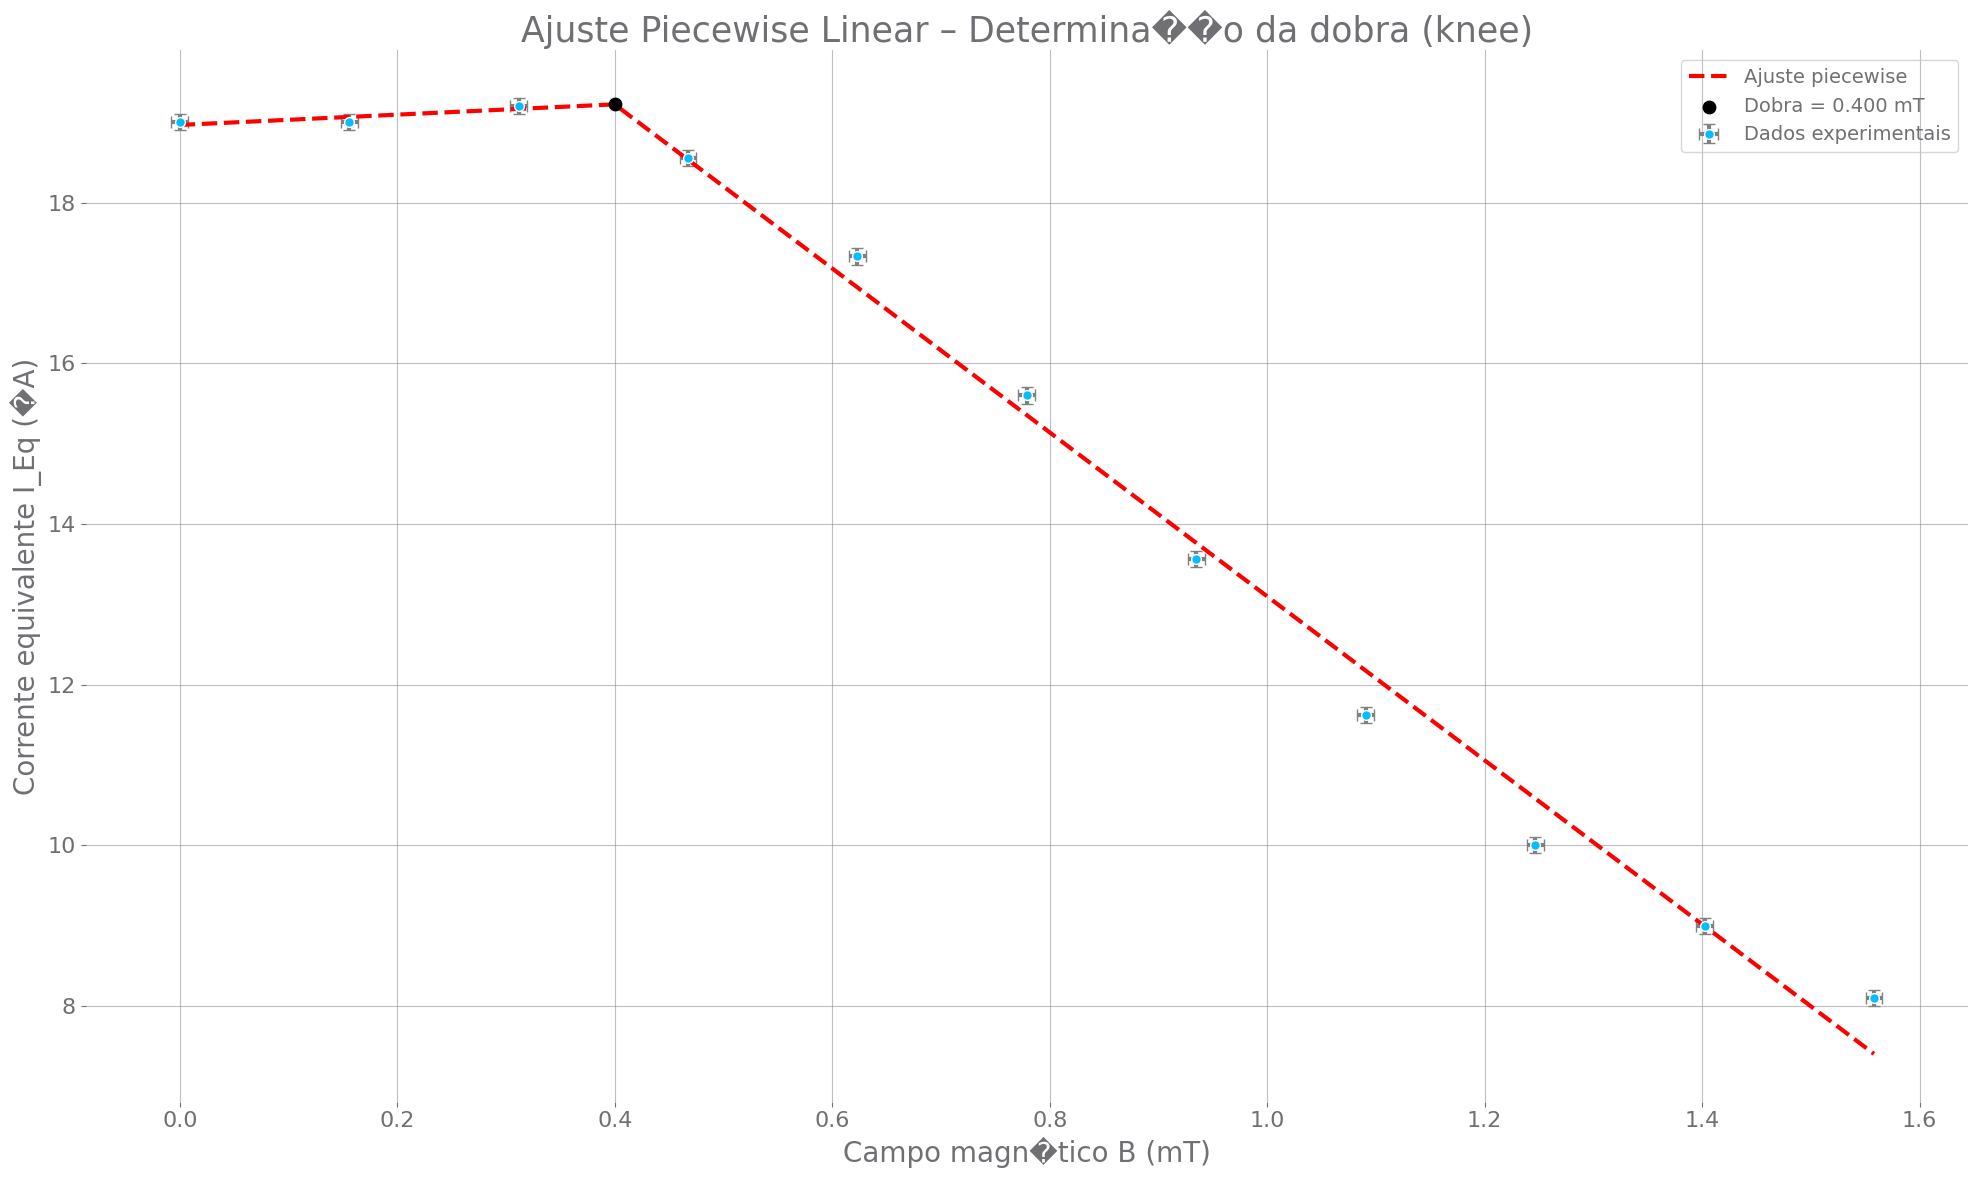

(np.float64(0.39986178753843327), array(19.22331736))

In [37]:
caminho = "/home/joliveira/Documents/termoionico/Dados Obitdos 27.11.2025/"

plot_piecewise_knee(
    f"{caminho}m_3-T_1700C.ods",
    salvar=True,
    pasta_saida="Gráficos Parte 2"
)
